In [11]:
%load_ext autoreload
%autoreload 2
import random
import torch
import torch.nn as nn
import plotly.express as px
import pickle 
from collections import defaultdict
from seqmodels import *
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
DOMAIN = 'pollini'
models_path = 'models/'+DOMAIN+"_model.pt"

In [13]:
def load_models(models_path):
    models = torch.load(models_path)
    device = "cuda:0"
    params = models['params']
    encoder = EncoderRNN(params["n_node"]+2, params["hidden_size"]).to(device)
    decoder = AttnDecoderRNN(params["hidden_size"], params["n_node"]+2, dropout_p=params["dp"]).to(device)

    encoder.load_state_dict(models['encoder'])
    decoder.load_state_dict(models['decoder'])
    encoder.eval()
    decoder.eval()
    return encoder, decoder

## Get Error trajs

In [14]:
encoder, decoder = load_models(models_path)
error_trajs = pickle.load(open("./data/"+DOMAIN+"/errors.pkl", "rb"))

In [15]:
## Filter trajs and remove 1 and 2 loops
CUTOFF = 10
error_trajs = list(map(lambda x: remove_2loops(remove_self_loops(x)), error_trajs))
error_trajs = list(filter(lambda x: len(x) > CUTOFF, error_trajs))

## get unique error_sigs
err_sigs = set({})
for traj in error_trajs:
    sigs = [node for node in traj if isinstance(node, str)]
    err_sigs.update(set(sigs))
err_sigs = list(err_sigs)

## Get trajs for each error_sig
error_groups=defaultdict(set)
for traj_index, traj in enumerate(error_trajs):
    for node in traj:
        if isinstance(node, str):
            error_groups[node].update({traj_index})

## Filter Errors with too few trajs
errors = []
for err in err_sigs:
    if len(error_groups[err])>CUTOFF:
        errors.append(err)

In [6]:
def error_compress(traj):
    """function return traj with errors removed 
    and for each error the index where it occurs
    """
    errors = set({})
    err_index = defaultdict(list)
    skip = []
    for i, node in enumerate(traj):
        if isinstance(node, str):
            if node not in errors:
                errors.add(node)
            skip.append(i)
            err_index[node].append(i)
    return [traj[i] if i not in skip else -1 for i,_ in enumerate(traj) ], err_index

## Process Error trajs

In [7]:
# traj summarization -> distance to checkout
# error_window (what is happening in the neighborhood of the issue)
# 

## windowing 
- take any number of steps before the error (with max_steps) and predict next k steps
    - combine k steps from all the sessions
        - popular nodes/bigrams/trigrams on each step 
        - popular nodes/bigrams/trigrams overall
        - 

## Compute predictions

In [8]:
error = errors[0]
trajs = error_groups[error]

preds = []
truth = []

for t in trajs:
    traj = error_trajs[t]
    new_traj, errors = error_compress(traj)

In [9]:
encoder.embedding(torch.tensor([3], device="cuda:0"))

tensor([[ 1.0896, -1.2097,  1.2131,  0.5490, -0.4576,  0.9174,  0.1916,  0.2350,
          0.2520, -0.3583, -0.0692,  0.1689, -0.9393, -0.0305, -1.0283, -1.8442,
          0.8792, -1.2688,  0.2098,  2.8370, -0.2089, -1.3014, -0.6359, -0.1833,
         -0.1938, -0.9402,  1.2980,  0.5796,  0.0826,  1.1190,  0.1688,  0.2770,
         -0.9297,  0.0977, -0.0276, -0.7993, -1.6771,  0.2449,  2.0590,  0.9792,
         -1.1050,  1.9201, -0.4736, -0.3071,  1.6295, -0.0381,  0.6796, -0.4495,
         -0.4929, -0.9417, -0.3667,  0.6080,  1.4821,  0.0034, -0.2028, -0.0920,
          1.8703,  0.4921, -0.8784, -2.0933,  0.5132, -0.3129, -0.4356, -0.1356,
         -0.2727, -0.6167,  0.0478,  1.4605, -0.9442,  0.0242,  1.0940, -0.7101,
          0.1105, -0.1652,  1.0793, -0.8148, -0.1969, -0.9207,  0.6889,  1.0390,
          0.6502,  0.5918, -1.2153, -0.5922,  0.9265, -0.9813,  0.3893, -1.3829,
         -1.3517,  0.2337,  0.2557,  0.4679,  0.2638,  0.7584, -0.2442, -0.5596,
         -1.0670,  2.4932, -

## Strategies to compute differences

In [ ]:
## compute node, bi-gram and tri-gram distributions for preds and truths
## compare these distributions to find differences
## distributions of distance to checkout (no-order)

## trajectory divergence (one-by-one)
## destination divergence
## 

## Strategies to compute input_length seq and output_seq

> To train
+ train with min. n (>=3) and k to EOS or k_max
+ small n and small k (5-10)
----
> To predict
+ n-before error to k-after error
    - fixed n-k --- ignore other errors and focus only on nodes
    - flexbile n (pos before to start or the error before with max. n) -> 
    - k from target 

## Find differences -- pred v occurred

In [19]:
lengths = []

for i in error_trajs:
    lengths.append(len(i))

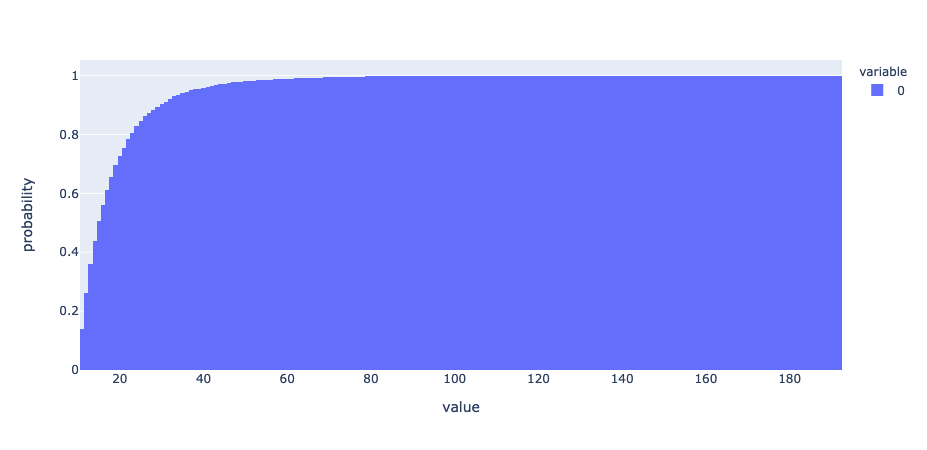

In [25]:
px.histogram(lengths, cumulative=True, histnorm='probability')